In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# pipeline
# create rag database
# segformer
# llm
# response

# Imports

In [8]:
%%capture
%pip install langchain langchain-community sentence-transformers langchain-huggingface faiss-cpu transformers langchain-chroma

In [9]:
from huggingface_hub import login
login("")

In [10]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.docstore.document import Document
from langchain.chains import RetrievalQA
from langchain_huggingface import HuggingFacePipeline
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain.chains import RetrievalQA


# Vector stores

In [11]:
raw_docs = [
    Document(
        page_content="Bondi Beach NSW, Has great beaches and lot of amazing activities to do with restaurants and cliff walks.",
        metadata={"tags": "sand, cliff", "location": "Bondi"}
    ),
    Document(
        page_content="You can also experience a great refreshing time in Cooge Beach sydney with good and gentle waves for surfing \
and swimming with many restaurant and colorful people with a beautiful cliff walk and park beside the beach",
        metadata={"tags": "sand, cliff", "location": "Cooge"}
    ),
    Document(
        page_content="Snow Mountain NSW, is a snowy mountain with rides and snow skating plus beautiful sunrise scenaries.",
        metadata={"tags": "mountain, snow", "location": "Snowy Mountains"}
    )
]

### Vector store function

In [12]:

def chroma_storeage(raw_docs):
    
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
    
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=20)
    chunks = splitter.split_documents(raw_docs)
    # vectorstore = FAISS.from_documents(chunks, embeddings)
    vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings)


/tmp/ipykernel_55/29558883.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### testing vector stores

In [27]:
print(chunks, "\n\n")
print(print(vectorstore.get()["documents"]), "\n\n")
for i in vectorstore.similarity_search_with_score("I want a trip where I can relax in a beach Tags: [beach, sand]", k=3):
    print(i)

[Document(metadata={'tags': 'beach, cliff', 'location': 'Bondi'}, page_content='Bondi Beach NSW, Has great beaches and lot of amazing activities to do with restaurants and cliff walks.'), Document(metadata={'tags': 'beach, cliff', 'location': 'Cooge'}, page_content='You can also experience a great refreshing time in Cooge Beach sydney with good and gentle waves for surfing and swimming with many restaurant and colorful people with a beautiful cliff walk and park beside the beach'), Document(metadata={'tags': 'mountain, snow', 'location': 'Snowy Mountains'}, page_content='Snow Mountain NSW, is a snowy mountain with rides and snow skating plus beautiful sunrise scenaries.')] 




# Model + Pipeline

In [22]:

model_id = "meta-llama/Meta-Llama-3-8B-Instruct" # Or any HF model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    device_map="auto"
)

# Create a HF pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=512, return_full_text=True)
llm = HuggingFacePipeline(pipeline=pipe)

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Device set to use cuda:0


# Retrieval

In [23]:
from langchain_core.prompts import PromptTemplate
template = """[INST] <<SYS>>
You are a helpful travel assistant. Use ONLY the provided context to answer. 
If the answer isn't in the context, say you don't know. DO NOT use outside knowledge.
<</SYS>>

Context: {context}
Question: {question} [/INST]
Answer:"""

template2 = """<s>[INST] <<SYS>>
You are an assistant that answers ONLY using the provided context.
If the answer is not clearly in the context, reply exactly:
"I don't know based on the provided context."
Here are examples:

CONTEXT:
Bondi Beach NSW, has great beaches and restaurants and cliff walks.
QUESTION:
I want a trip where I can relax in a beach after that a mountainous area.
ANSWER:
I don't know based on the provided context.

CONTEXT:
1. Bondi Beach NSW, has great beaches and restaurants and cliff walks.
2. You can also experience a great refreshing time in Cooge Beach sydney with good and gentle waves for surfing
and swimming with many restaurant and colorful people with a beautiful cliff walk and park beside the beach 
QUESTION:
I want a trip where I can relax in a beach and have some fun and do some activites and can you recommend where can I also go for mountain walk as well.
ANSWER:
Thats great! My recommendation is that you can try Bondi Beach in Sydney NSW where you have a wonderful beach experience with 
lot of activities like swimming and cliff walk. 
You could also go to Cooge Beach in Sydney NSW which also has nice relaxing beach with gentle waves perfect for swimming,
and surfing. It also has a beautiful cliff beside it with a nice park for enjoying a relaxing time.
Sorry I cannot recommend you anything about mountains as if no knowledge of it. 

CONTEXT:
Bondi Beach NSW, has great beaches and restaurants and cliff walks.
QUESTION:
What kind of activities can I do there?
ANSWER:
Based on the context you can enjoy the beach, visit restaurants, and walk along the cliffs.

Now follow the same rules for the new question.
<</SYS>>



CONTEXT:
{context}
QUESTION:
{question}
[/INST]
ANSWER:

"""

custom_prompt = PromptTemplate(
    template=template2, 
    input_variables=["context", "question"]
)

# Set up the retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})

# Create the final chain
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    chain_type_kwargs={"prompt": custom_prompt}
)



# SegTransformer

In [29]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import torch
import matplotlib.pyplot as plt
import numpy as np

processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

In [31]:
def image_seg(url):
    image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
    
    # 3. Process and Predict
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
    
    # 4. Resize back to original image size
    upsampled_logits = torch.nn.functional.interpolate(
        logits, size=image.size[::-1], mode="bilinear", align_corners=False
    )
    prediction = upsampled_logits.argmax(1)[0].numpy()
    
    # 5. Get labels found in this specific image
    unique_classes = np.unique(prediction)
    found_labels = [model.config.id2label[class_id] for class_id in unique_classes]
    
    print(f"Labels found in image: {found_labels}")
    
    # 6. Visualization
    plt.imshow(image)
    plt.imshow(prediction, alpha=0.5) # Overlay the segments
    plt.title(f"Found: {', '.join(found_labels[:5])}...")
    plt.axis('off')
    plt.show()
    return(found_labels)

# Query

In [36]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ9PfBkJ1_Xy4PIxhydXUYwZGS6hYOvMhHbqA&s"
# image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
requests.get(url, stream=True)

<Response [200]>

Labels found in image: ['building', 'sky', 'tree', 'grass', 'person', 'earth', 'mountain', 'sea', 'fence', 'sand', 'hill', 'land']


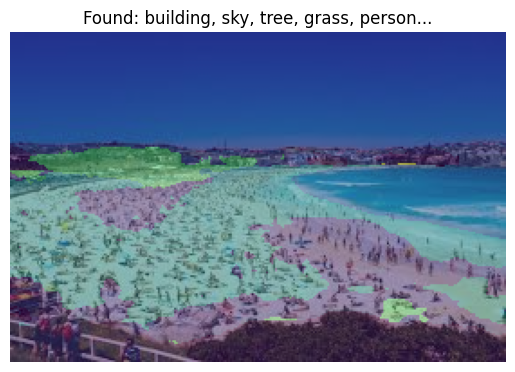

In [38]:
image_res = image_seg(url)


In [25]:
query = "I want a trip where I can relax and go for a swim and beach experience"
print(qa_chain.invoke(query)["result"])

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<s>[INST] <<SYS>>
You are an assistant that answers ONLY using the provided context.
If the answer is not clearly in the context, reply exactly:
"I don't know based on the provided context."
Here are examples:

CONTEXT:
Bondi Beach NSW, has great beaches and restaurants and cliff walks.
QUESTION:
I want a trip where I can relax in a beach after that a mountainous area.
ANSWER:
I don't know based on the provided context.

CONTEXT:
1. Bondi Beach NSW, has great beaches and restaurants and cliff walks.
2. You can also experience a great refreshing time in Cooge Beach sydney with good and gentle waves for surfing
and swimming with many restaurant and colorful people with a beautiful cliff walk and park beside the beach 
QUESTION:
I want a trip where I can relax in a beach and have some fun and do some activites and can you recommend where can I also go for mountain walk as well.
ANSWER:
Thats great! My recommendation is that you can try Bondi Beach in Sydney NSW where you have a wonderful 

In [26]:
import torch
print(torch.cuda.memory_summary())

import gc

# Delete variables/models before clearing cache (example)
# del model
# del optimizer

torch.cuda.empty_cache()
gc.collect()

print(torch.cuda.memory_summary())


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   7253 MiB |   7378 MiB |  46613 MiB |  39360 MiB |
|       from large pool |   7252 MiB |   7353 MiB |  43171 MiB |  35919 MiB |
|       from small pool |      0 MiB |     33 MiB |   3442 MiB |   3441 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   7253 MiB |   7378 MiB |  46613 MiB |  39360 MiB |
|       from large pool |   7252 MiB |   7353 MiB |  43171 MiB |